In [1]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_dir = '/Users/akshit/repos/BackgroundMattingV2/data'
fgr_dir = '{}/PhotoMatte85'.format(data_dir)
bgr_dir = '{}/Backgrounds'.format(data_dir)

In [3]:
fgr_files = ['{}/{}'.format(fgr_dir, f) for f in os.listdir(fgr_dir)]
bgr_files = ['{}/{}'.format(bgr_dir, f) for f in os.listdir(bgr_dir)]

fgr_path = fgr_files[0] 
bgr_path = bgr_files[0]

In [4]:
fgr = cv.imread(fgr_path,cv.IMREAD_UNCHANGED)
fgr = cv.cvtColor(fgr, cv.COLOR_BGRA2RGBA)

bgr = cv.imread(bgr_path)
bgr = cv.cvtColor(bgr, cv.COLOR_BGR2RGB)

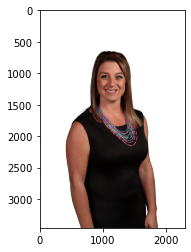

In [5]:
plt.imshow(fgr)

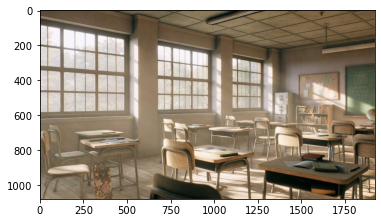

In [6]:
plt.imshow(bgr)

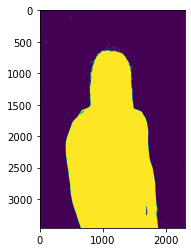

In [7]:
pha = fgr[:, :, -1]
plt.imshow(pha>1)

In [85]:
fh,fw,_ = fgr.shape
bh,bw,_ = bgr.shape

scale = min(bw/fw, bh/fh)
th, tw, _ = (scale*np.array(fgr.shape)).astype(int)
trg_size = (tw, th)
im = cv.resize(fgr, trg_size)

In [89]:
delta = np.array(bgr.shape) - np.array(im.shape)
delta[-1]=0
pads = np.stack((delta//2,delta-delta//2), axis=1)
im = np.pad(im, pads)

In [91]:
assert im.shape[:-1] == bgr.shape[:-1]
pha = im[:,:,-1]
pha= np.expand_dims(pha.astype(float)/ 255., axis=2)
c_im = (pha*im[:,:,:3] + (1-pha)*bgr).astype(np.uint8)

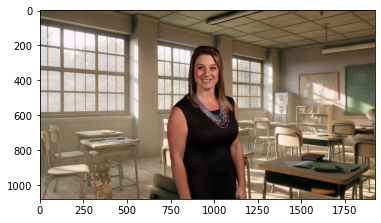

In [92]:
plt.imshow(c_im)
# plt.hist(im[:,:,-1].flatten())
# im.shape

In [95]:
im = cv.imread('/Users/akshit/repos/coreml_conversion/raw/2007_000032.png')

In [139]:
# plt.imshow(im)
from PIL import Image
filename='/Users/akshit/repos/coreml_conversion/raw/2007_000032.png'
seg_map = np.array(Image.open(filename))

In [106]:
# plt.imshow(seg_map)
# plt.hist(seg_map.flatten())
set(seg_map.flatten())

{0, 1, 15, 255}

In [108]:
pil_image = Image.fromarray(seg_map.astype(dtype=np.uint8))

In [109]:
# pil_image.save(f, 'PNG')
pil_image.save('foo.png', 'PNG')

In [112]:
im = cv.imread('foo.png', cv.IMREAD_UNCHANGED)

In [119]:
# im.shape
seg_map = np.array(Image.open('foo.png'))

In [130]:
# plt.hist(seg_map.flatten())
# np.unique(seg_map.flatten(), return_counts=True)
# np.unique(fgr[:,:,-1].flatten(),return_counts=True)
pha = fgr[:,:,-1]
bin_map = pha>=1

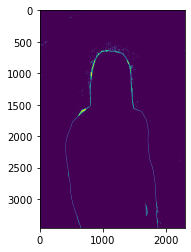

In [136]:
plt.imshow(np.logical_and(pha>=1,pha<123))

In [138]:
pha_thresh = np.iinfo(np.uint8).max//2
seg_map = np.zeros_like(pha)
seg_map[pha >= pha_thresh] = 1
# ignore label
seg_map[np.logical_and(pha > 0, pha < pha_thresh)] = 255

255

In [154]:
def rolling_access(els, el_idx):
    return els[el_idx%len(els)]

def get_files(base_dir):
    files = ['{}/{}'.format(base_dir, f) for f in os.listdir(base_dir)]
    return files

def fit_fgr_within_bgr(fgr, bounding_im_shape):
    fh,fw,_ = fgr.shape
    bh,bw,_ = bounding_im_shape

    scale = min(bw/fw, bh/fh)
    th, tw, _ = (scale*np.array(fgr.shape)).astype(int)
    trg_size = (tw, th)
    return cv.resize(fgr, trg_size)

def pad_to_match_dims(src_im, trg_shape):
    delta = np.array(trg_shape) - np.array(src_im.shape)
    delta[-1]=0
    pads = np.stack((delta//2,delta-delta//2), axis=1)
    src_padded = np.pad(src_im, pads)
    return src_padded

def compose_fgr_onto_bgr(fgr, bgr):
    assert fgr.shape[:-1] == bgr.shape[:-1]
    pha = fgr[:,:,-1]
    pha = np.expand_dims(pha.astype(float)/ 255., axis=2)
    composed_im = (pha*fgr[:,:,:3] + (1-pha)*bgr).astype(np.uint8)
    return composed_im

def alpha_to_binary_seg_map(pha):
    pha_thresh = np.iinfo(np.uint8).max//2
    seg_map = np.zeros_like(pha)
    seg_map[pha >= pha_thresh] = 1
    # ignore label
    seg_map[np.logical_and(pha > 0, pha < pha_thresh)] = 255
    return seg_map

def get_composed_and_label_img(fgr, bgr):
    fgr = fit_fgr_within_bgr(fgr, bgr.shape)
    fgr = pad_to_match_dims(fgr, bgr.shape)
    composed_im = compose_fgr_onto_bgr(fgr, bgr)
    alpha_channel = fgr[:,:,3]
    seg_map = alpha_to_binary_seg_map(alpha_channel)
    composed_im, seg_map = resize_within_bound(composed_im), resize_within_bound(seg_map)
    return composed_im, seg_map

def resize_within_bound(im, edge_len=513):
    h, w = im.shape[0], im.shape[1]
    scale = edge_len/min(h,w)
    th, tw = (scale*np.array(im.shape[:2])).astype(int)
    trg_size = (tw, th)
    return cv.resize(im, trg_size)

def prepare_photomatte_dataset(base_dir='/Users/akshit/repos/BackgroundMattingV2/data'):
    fgr_dir = '{}/PhotoMatte85'.format(base_dir)
    bgr_dir = '{}/Backgrounds'.format(base_dir)
    fgr_files = get_files(fgr_dir)
    bgr_files = get_files(bgr_dir)
    print('Found:\n{} Foreground images\n{} Bg images'.format(len(fgr_files), len(bgr_files)))
    
    output_dir = '/Users/akshit/repos/tensorflow_models/research/deeplab/data/PhotoMatte'
    scene_op_dir = '{}/JPEGImages'.format(output_dir)
    seg_op_dir = '{}/SegmentationClass'.format(output_dir)
    os.makedirs(scene_op_dir, exist_ok=True)
    os.makedirs(seg_op_dir, exist_ok=True)
    
    
    total_op_imgs = max(len(fgr_files), len(bgr_files))
    data_list_file = open("{}/train.txt".format(output_dir), "w")

    for file_idx in range(total_op_imgs):
        fgr_path = rolling_access(fgr_files, file_idx)
        bgr_path = rolling_access(bgr_files, file_idx)
        
        fgr = cv.imread(fgr_path,cv.IMREAD_UNCHANGED)
        bgr = cv.imread(bgr_path)
        
        op_file_name = '{0:03d}'.format(file_idx)
        scene_im, seg_map = get_composed_and_label_img(fgr, bgr)
        
        label_im = Image.fromarray(seg_map.astype(dtype=np.uint8))
        label_file_path = '{}/{}.png'.format(seg_op_dir, op_file_name)
        label_im.save(label_file_path, 'PNG')
        
        scene_file_path = '{}/{}.jpg'.format(scene_op_dir, op_file_name)
        cv.imwrite(scene_file_path, scene_im)
        data_list_file.write("{}\n".format(op_file_name))
        print('Completed {}/{}...'.format(file_idx, total_op_imgs))
    data_list_file.close()

prepare_photomatte_dataset()

Found:
85 Foreground images
193 Bg images
Completed 0/193...
Completed 1/193...
Completed 2/193...
Completed 3/193...
Completed 4/193...
Completed 5/193...
Completed 6/193...
Completed 7/193...
Completed 8/193...
Completed 9/193...
Completed 10/193...
Completed 11/193...
Completed 12/193...
Completed 13/193...
Completed 14/193...
Completed 15/193...
Completed 16/193...
Completed 17/193...
Completed 18/193...
Completed 19/193...
Completed 20/193...
Completed 21/193...
Completed 22/193...
Completed 23/193...
Completed 24/193...
Completed 25/193...
Completed 26/193...
Completed 27/193...
Completed 28/193...
Completed 29/193...
Completed 30/193...
Completed 31/193...
Completed 32/193...
Completed 33/193...
Completed 34/193...
Completed 35/193...
Completed 36/193...
Completed 37/193...
Completed 38/193...
Completed 39/193...
Completed 40/193...
Completed 41/193...
Completed 42/193...
Completed 43/193...
Completed 44/193...
Completed 45/193...
Completed 46/193...
Completed 47/193...
Complete